In [30]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout,Conv2D,MaxPool2D,Flatten,Dense,Activation,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns

In [20]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [15]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

In [3]:
filenames = os.listdir("./train")
categories = []
for file in filenames:
    cat = file.split('.')[0]
    if cat == 'dog':
        categories.append(1)
    else:
        categories.append(0)


In [4]:
data = pd.DataFrame({'filename':filenames,'category':categories })

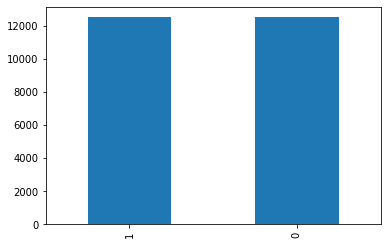

In [5]:
data.category.value_counts().plot(kind='bar')

In [6]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [7]:
early = EarlyStopping(patience=10)
red = ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5,min_lr=0.00001)
callbacks = [early,red]

In [8]:
data.category =  data.category.map({0:'cat',1:'dog'})
data.isna().sum()

filename    0
category    0
dtype: int64

In [9]:
train, validate = train_test_split(data, test_size=0.20, random_state=42)

In [10]:
train.reset_index(drop=True,inplace=True)
validate.reset_index(drop=True,inplace=True)

In [11]:
total_train = train.shape[0]
total_validate = validate.shape[0]
batch_size=15

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [17]:
validation_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [22]:
FAST_RUN=True
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1333 steps, validate for 333 steps
Epoch 1/3
1333/1333 [==============================] - 2016s 2s/step - loss: 0.6916 - accuracy: 0.6404 - val_loss: 0.6473 - val_accuracy: 0.6368
Epoch 2/3
1333/1333 [==============================] - 2042s 2s/step - loss: 0.5501 - accuracy: 0.7226 - val_loss: 0.6854 - val_accuracy: 0.6773
Epoch 3/3
1333/1333 [==============================] - 2085s 2s/step - loss: 0.4928 - accuracy: 0.7651 - val_loss: 0.5495 - val_accuracy: 0.7201


In [23]:
model.save_weights("model.h5")

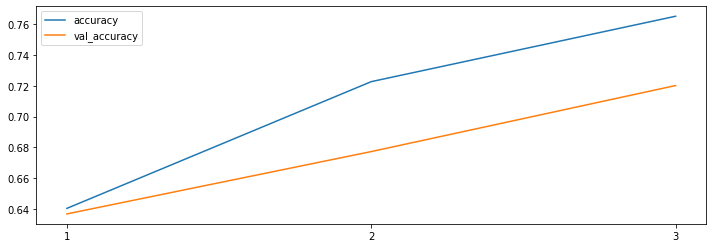

In [51]:
a = {'accuracy':history.history['accuracy'],'val_accuracy':history.history['val_accuracy']}
fig,ax = plt.subplots(figsize=(12,4))
sns.lineplot(x = range(1,4),y = a['accuracy'],label='accuracy')
sns.lineplot(x = range(1,4),y = a['val_accuracy'],label='val_accuracy')
ax.set_xticks(range(1,4))

In [53]:
test_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [58]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    "./test1/", 
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [60]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [72]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df

,filename,category
0,1046.jpg,0
1,8309.jpg,1
2,11584.jpg,1
3,2258.jpg,1
4,2934.jpg,0
...,...,...
12495,11487.jpg,1
12496,8346.jpg,1
12497,1967.jpg,0
12498,7971.jpg,0


In [73]:
test_df.category =  test_df.category.map({0:'cat',1:'dog'})
test_df

,filename,category
0,1046.jpg,cat
1,8309.jpg,dog
2,11584.jpg,dog
3,2258.jpg,dog
4,2934.jpg,cat
...,...,...
12495,11487.jpg,dog
12496,8346.jpg,dog
12497,1967.jpg,cat
12498,7971.jpg,cat


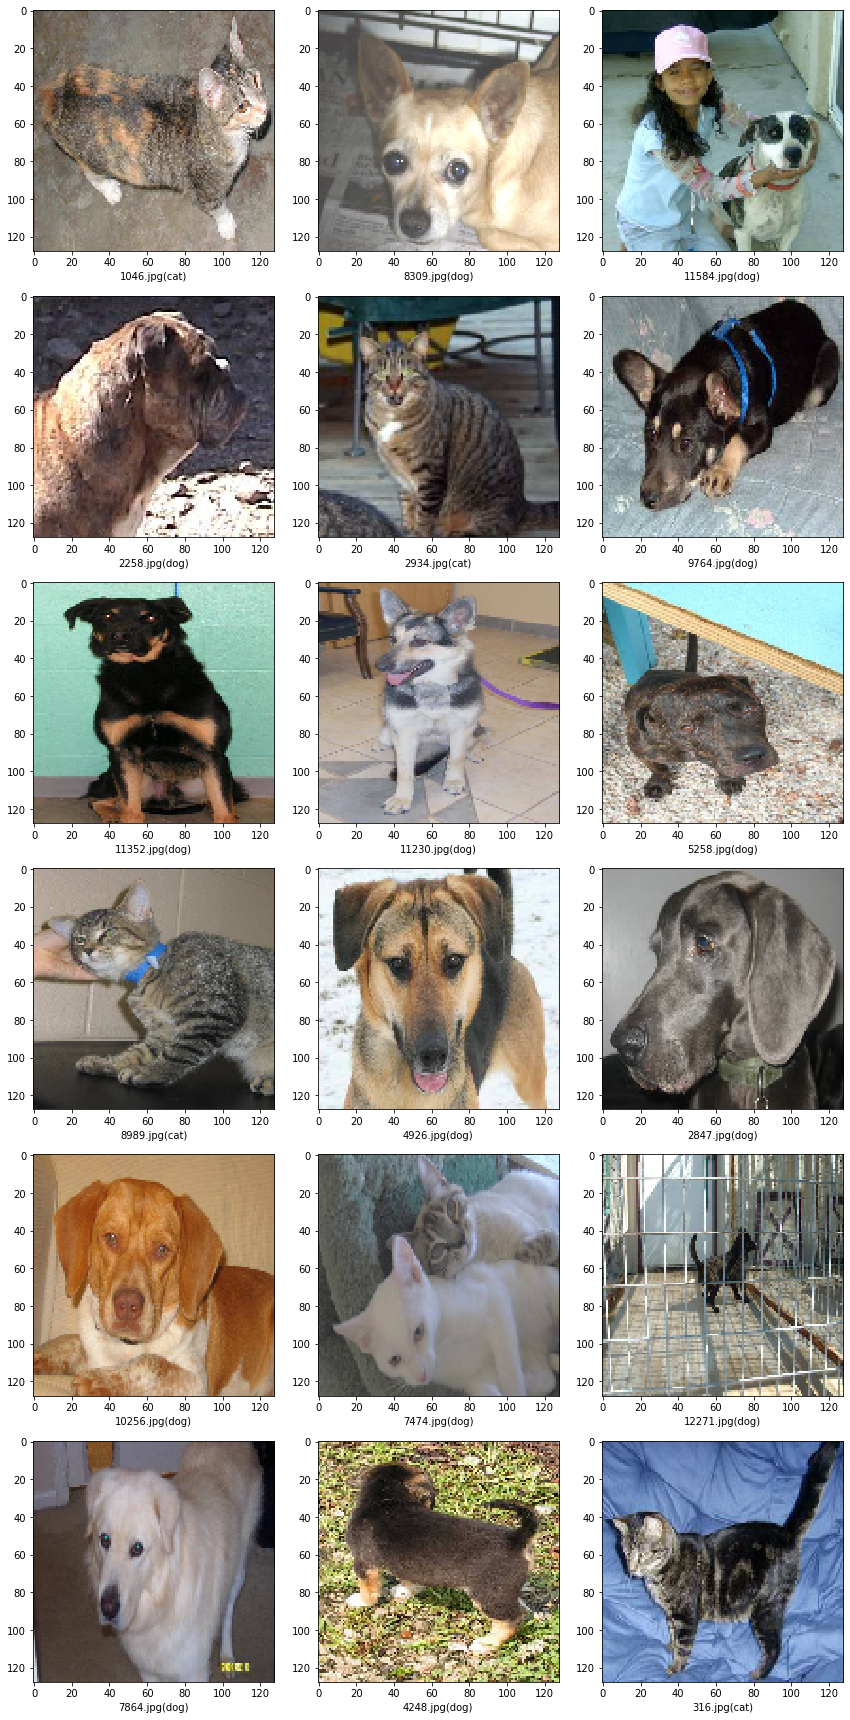

In [75]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [77]:
test_df.category.value_counts()

dog    7909
cat    4591
Name: category, dtype: int64